In [52]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [54]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [55]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [56]:
'''
Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. 
Аргумент   history_size — это размер последнего временного интервала, 
target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. 
Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.
'''
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [57]:
'''
В обеих частях руководства первые 300 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). 
В этом случае объём обучающих данных составляет примерно 2100 дней.
'''

TRAIN_SPLIT = 300000

''' Для обеспечения воспроизводимости результатов устанавливается функция seed. '''
tf.random.set_seed(13)

In [58]:
''' 
Модель 1. Прогнозирование на основе одномерного временного ряда

В первой модели, используется только один признак – температура; 
обученная модель будет использоваться для прогнозирования будущих значений температуры.
'''

' \nЧасть 1. Прогнозирование на основе одномерного временного ряда\n\nВ первой части вы будете обучать модель, используя только один признак – температуру; \nобученная модель будет использоваться для прогнозирования будущих значений температуры.\n'

In [59]:
''' Для начала извлечем только температуру из набора данных. '''

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<Axes: xlabel='Date Time'>], dtype=object)

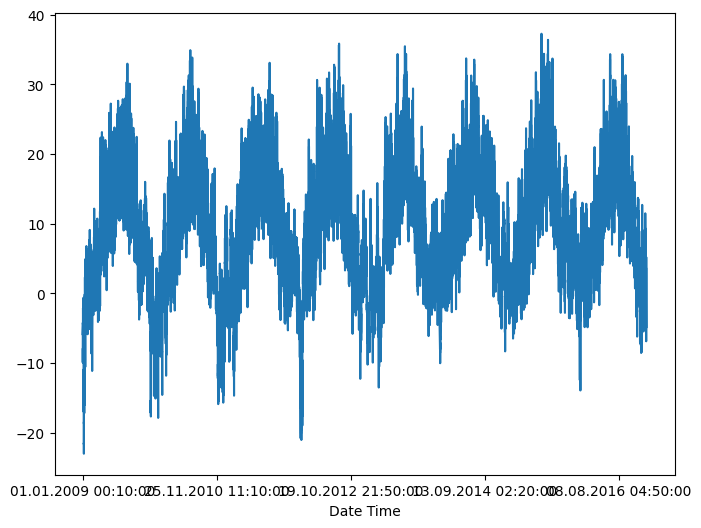

In [60]:
''' И посмотрим, как эти данные изменяются во времени. '''
uni_data.plot(subplots=True)

In [61]:
uni_data = uni_data.values

In [62]:
''' 
Перед обучением искусственной нейронной сети (далее – ИНС) важным шагом является масштабирование данных. 
ПОэтому выполним стандартизацию данных.

Примечание: стандартизация должна выполняться только c использованием обучающих данных.
'''

' \nПеред обучением искусственной нейронной сети (далее – ИНС) важным шагом является масштабирование данных. \nОдним из распространённых способов выполнения масштабирования является стандартизация (standardization), \nвыполняемая путём вычитания среднего значения и деления на стандартное отклонение для каждого признака. \nВы также можете использовать метод tf.keras.utils.normalize, который масштабирует значения в диапазон [0,1].\n\nПримечание: стандартизация должна выполняться только c использованием обучающих данных.\n'

In [63]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [64]:
''' Стандартизация данных '''
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [65]:
''' 
Далее подготовим данные для модели с одномерным входом. На вход в модель будут подаваться 
последние 20 зарегистрированных наблюдений за температурой, и модель необходимо обучить 
прогнозировать температуру на следующем шаге по времени.
'''

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [66]:
''' Результаты применения функции univariate_data. '''
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [67]:
''' 
Теперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. 
Передаваемая в ИНС информация выделена синим цветом, красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.
'''

' \nТеперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. \nПередаваемая в ИНС информация выделена синим цветом, красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.\n'

In [68]:
def create_time_steps(length):
  return list(range(-length, 0))

In [69]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\artem\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

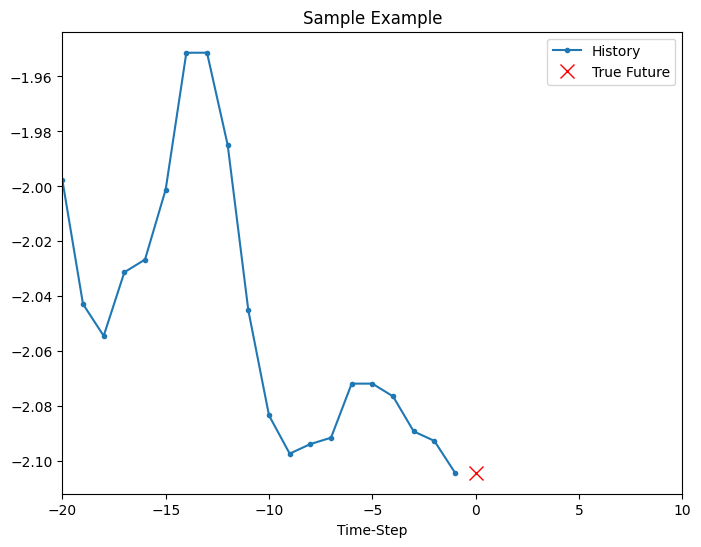

In [70]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [75]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [76]:
''' Видно, что LSTM требует определённой формы ввода данных, которые ему предоставляются. '''
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [77]:
''' Проверим выход модели. '''

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

''' 
Дополнение:
В общем плане РНС работают с последовательностями (sequences). Это означает, что подаваемые на вход модели данные должны иметь следующую форму:

[наблюдения, временной интервал, кол-во признаков]
Форма обучающих данных для модели с одномерным входом имеет следующий вид:

print(x_train_uni.shape)
(299980, 20, 1)
'''

8/8 [==============================] - 0s 2ms/step
(256, 1)


' \nДополнение:\nВ общем плане РНС работают с последовательностями (sequences). Это означает, что подаваемые на вход модели данные должны иметь следующую форму:\n\n[наблюдения, временной интервал, кол-во признаков]\nФорма обучающих данных для модели с одномерным входом имеет следующий вид:\n\nprint(x_train_uni.shape)\n(299980, 20, 1)\n'

In [78]:
''' 
Далее займёмся обучением модели. Из-за большого размера набора данных и в целях экономии времени каждая эпоха 
будет проходить только 200 шагов (steps_per_epoch=200) вместо полных данных обучения, как это обычно делается.
'''
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10


200/200 [==============================] - 3s 9ms/step - loss: 0.3555 - val_loss: 0.0999
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0981 - val_loss: 0.0406
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0481 - val_loss: 0.0276
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0355 - val_loss: 0.0237
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0270 - val_loss: 0.0224
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0289 - val_loss: 0.0220
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0266 - val_loss: 0.0204
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0258 - val_loss: 0.0201
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0254 - val_loss: 0.0191
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0233 - val_loss: 0.0185


In [79]:
''' 
Прогнозирование с использованием простой модели LSTM

После выполнения подготовки простой LSTM-модели, выполним несколько прогнозов.
'''

' \nПрогнозирование с использованием простой модели LSTM\n\nПосле выполнения подготовки простой LSTM-модели, выполним несколько прогнозов.\n'

8/8 [==============================] - 0s 2ms/step


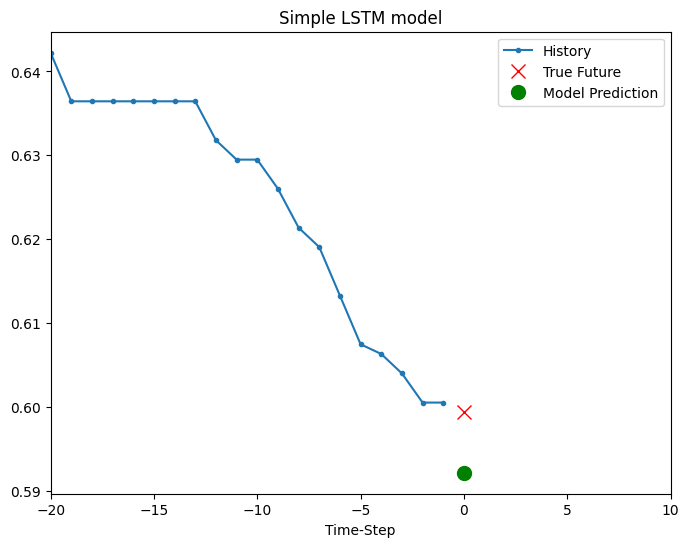

8/8 [==============================] - 0s 2ms/step


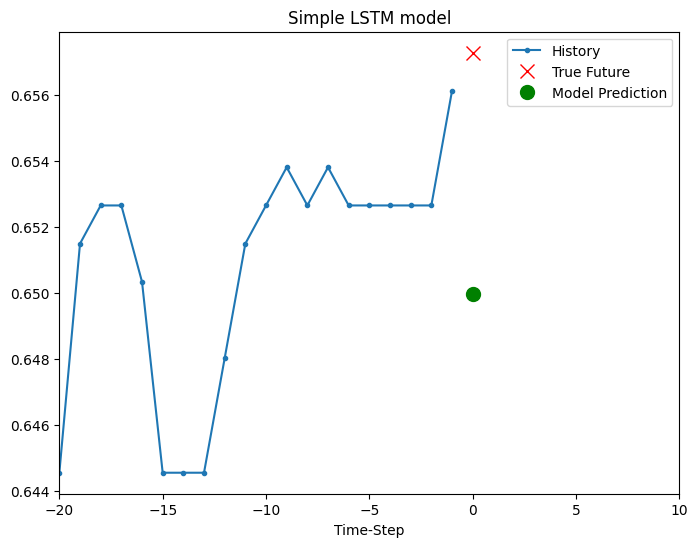

8/8 [==============================] - 0s 2ms/step


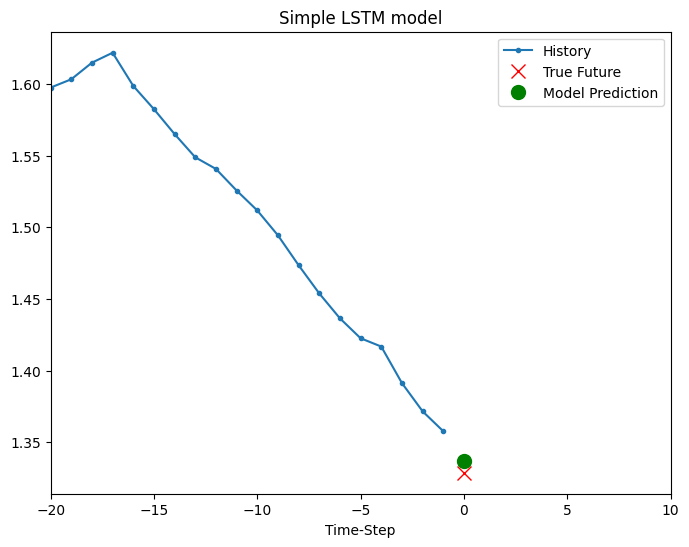

In [80]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [82]:
''' 
Модель 2: Прогнозирование на основе многомерного временного ряда

Как было сказано, исходный набор данных содержит 14 различных метеорологических показателей. 
Для простоты и удобства во второй части рассматриваются только три из них — температура воздуха, атмосферное давление и плотность воздуха.
'''

' \nЧасть 2: Прогнозирование на основе многомерного временного ряда\n\nКак было сказано, исходный набор данных содержит 14 различных метеорологических показателей. \nДля простоты и удобства во второй части рассматриваются только три из них — температура воздуха, атмосферное давление и плотность воздуха.\n'

In [83]:
''' Чтобы использовать больше признаков, их названия нужно добавить в список feature_considered. '''
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [84]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

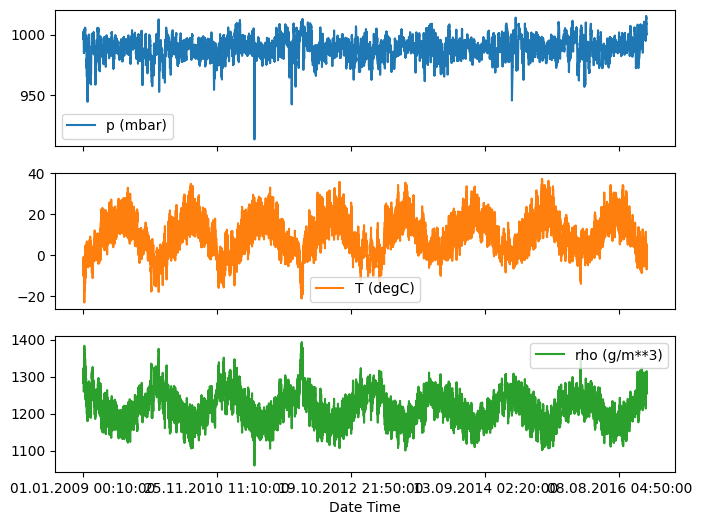

In [85]:
''' Посмотрим, как эти показатели изменяются во времени. '''
features.plot(subplots=True)

In [86]:
''' 
Как и ранее, первым шагом будет выполнение стандартизации набора данных.
'''
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [87]:
dataset = (dataset-data_mean)/data_std

In [88]:
''' 
Далее бедет два варианта: точечное и интервальное прогнозировании.
Суть в следующем. Если нужно, чтобы модель прогнозировала одно значение в будущем (например, значение температуры через 12 часов) (one-step/single step model), 
то и обучить модель вы должны таким образом, чтобы она прогнозировала только одно значение в будущем. 
Если задача состоит в прогнозировании интервала значений в будущем (например, ежечасные значения температуры в течение следующих 12 часов) (multi-step model), 
то и модель должна быть обучена прогнозировать интервал значений в будущем.
'''

' \nДополнение:\n\nДалее в руководстве будет рассказано о точечном и интервальном прогнозировании.\nСуть в следующем. Если вам нужно, чтобы модель прогнозировала одно значение в будущем (например, значение температуры через 12 часов) (one-step/single step model), \nто и обучить модель вы должны таким образом, чтобы она прогнозировала только одно значение в будущем. \nЕсли задача состоит в прогнозировании интервала значений в будущем (например, ежечасные значения температуры в течение следующих 12 часов) (multi-step model), \nто и модель должна быть обучена прогнозировать интервал значений в будущем.\n'

In [89]:
''' 
Точечное прогнозирование

В данном случае модель обучается прогнозированию одного значения в будущем на основе некой имеющейся истории.
Приведенная ниже функция выполняет ту же задачу организации временных интервалов лишь с тем отличием, что здесь она отбирает последние наблюдения
на основе заданного размера шага.
'''

' \nТочечное прогнозирование\n\nВ данном случае модель обучается прогнозированию одного значения в будущем на основе некой имеющейся истории.\nПриведенная ниже функция выполняет ту же задачу организации временных интервалов лишь с тем отличием, что здесь она отбирает последние наблюдения на основе заданного размера шага.\n'

In [90]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [91]:
''' 
Тут данные за последние пять (5) дней, то есть 720 наблюдениями (6х24х5). 
Допустим, что отбор данных проводится не каждые 10 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. 
Следовательно, историю последних пяти дней составляют 120 наблюдений (720/6). Для модели, выполняющей точечное прогнозирование, 
целью является значение температуры через 12 часов в будущем. В этом случае целевой вектор будет 
составлять температура после 72 (12х6) наблюдений.
'''

' \nВ данном руководстве ИНС оперирует данными за последние пять (5) дней, то есть 720 наблюдениями (6х24х5). \nДопустим, что отбор данных проводится не каждые 10 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. \nСледовательно, историю последних пяти дней составляют 120 наблюдений (720/6). Для модели, выполняющей точечное прогнозирование, \nцелью является значение температуры через 12 часов в будущем. В этом случае целевой вектор будет \nсоставлять температура после 72 (12х6) наблюдений (см. следующее дополнение. – Прим. переводчика).\n'

In [92]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [93]:
''' Проверим временной интервал. '''

print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [94]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


In [95]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [96]:
''' Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки. '''

for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 0s 7ms/step
(256, 1)


In [97]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 18s 84ms/step - loss: 0.3123 - val_loss: 0.2566
Epoch 2/10
200/200 [==============================] - 15s 75ms/step - loss: 0.2607 - val_loss: 0.2445
Epoch 3/10
200/200 [==============================] - 15s 75ms/step - loss: 0.2630 - val_loss: 0.2446
Epoch 4/10
200/200 [==============================] - 15s 75ms/step - loss: 0.2573 - val_loss: 0.2374
Epoch 5/10
200/200 [==============================] - 15s 77ms/step - loss: 0.2279 - val_loss: 0.2356
Epoch 6/10
200/200 [==============================] - 15s 75ms/step - loss: 0.2381 - val_loss: 0.2569
Epoch 7/10
200/200 [==============================] - 13s 65ms/step - loss: 0.2431 - val_loss: 0.2581
Epoch 8/10
200/200 [==============================] - 13s 65ms/step - loss: 0.2425 - val_loss: 0.2484
Epoch 9/10
200/200 [==============================] - 13s 65ms/step - loss: 0.2446 - val_loss: 0.2472
Epoch 10/10
200/200 [==============================] - 13s 65ms/step - loss: 0.237

In [98]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

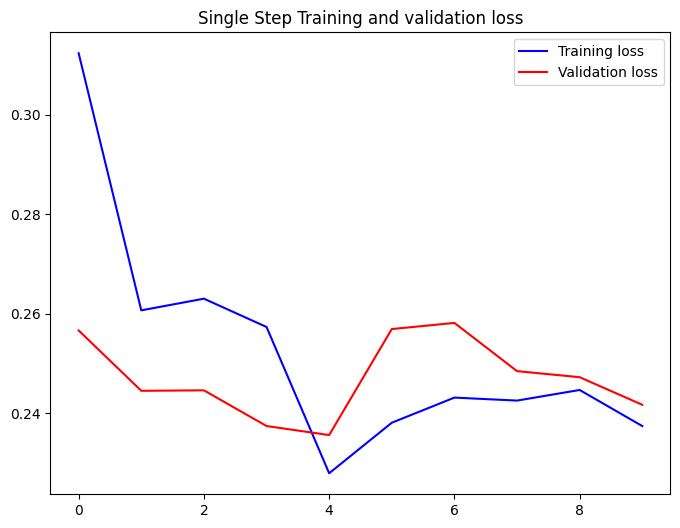

In [99]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


In [100]:
''' 
Выполнение точечного прогноза

Теперь, когда модель обучена, выполним несколько пробных прогнозов. На вход модели подаётся история наблюдений 3-х признаков за последние пять дней, 
отобранных каждый час (временной интервал = 120). Так как наша цель заключается в прогнозе только температуры, 
то синим цветом на графике отображены прошлые значения температуры (история). 
Прогноз выполнен на полдня в будущее (отсюда и разрыв между историей и спрогнозированным значением).
'''

' \nВыполнение точечного прогноза\n\nТеперь, когда модель обучена, выполним несколько пробных прогнозов. На вход модели подаётся история наблюдений 3-х признаков за последние пять дней, \nотобранных каждый час (временной интервал = 120). Так как наша цель заключается в прогнозе только температуры, \nто синим цветом на графике отображены прошлые значения температуры (история). \nПрогноз выполнен на полдня в будущее (отсюда и разрыв между историей и спрогнозированным значением).\n'

8/8 [==============================] - 0s 6ms/step


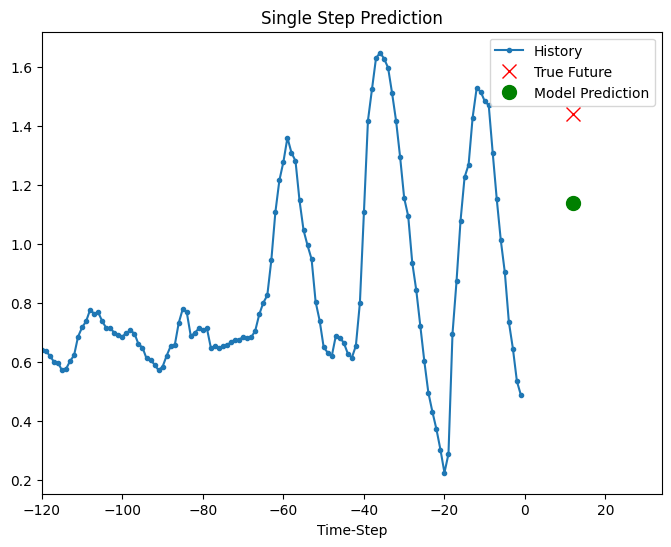

8/8 [==============================] - 0s 6ms/step


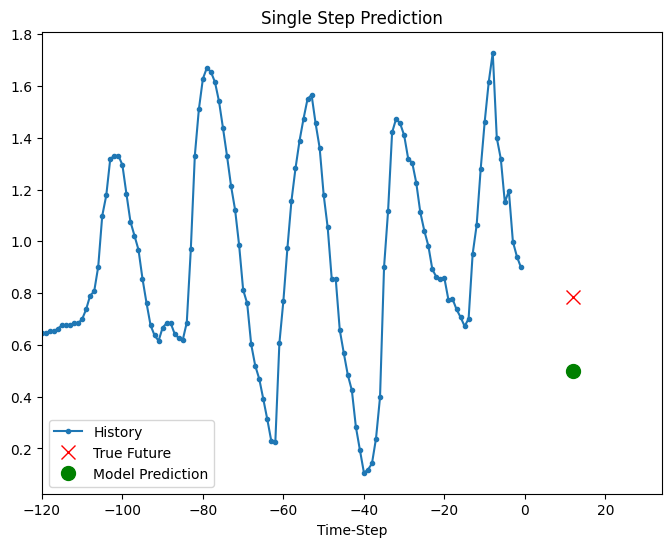

8/8 [==============================] - 0s 6ms/step


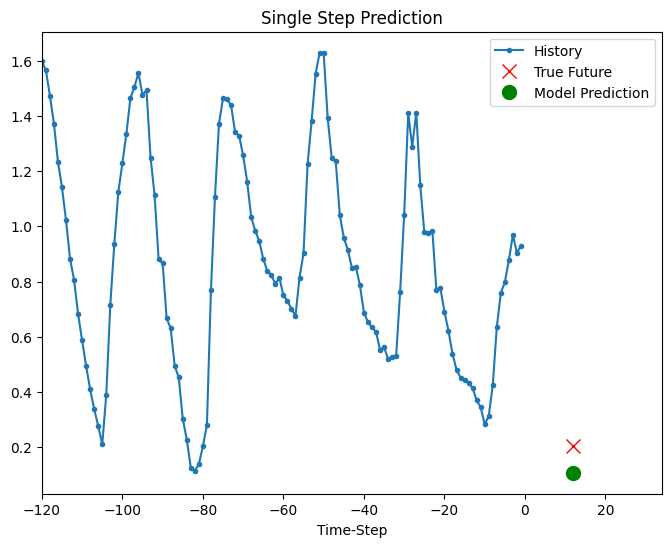

In [101]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [102]:
''' 
Интервальное прогнозирование

В этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. 
Таким образом, в отличие модели, прогнозирующей только на одно значение в будущее, данная модель прогнозирует последовательность значений в будущем.

Допустим, как и в случае с моделью, выполняющей точечное прогнозирование, для модели, выполняющей интервальное прогнозирование, 
обучающими данными являются почасовые замеры последних пяти дней (720/6). Однако в данном случае модель необходимо обучить прогнозировать 
температуру на следующие 12 часов. Поскольку наблюдения регистрируются каждые 10 минут, выход (output) модели должен состоять из 72 прогнозов. 
Для выполнения этой задачи необходимо подготовить набор данных заново, но с другим целевым интервалом.
'''

' \nИнтервальное прогнозирование\n\nВ этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. \nТаким образом, в отличие модели, прогнозирующей только на одно значение в будущее, данная модель прогнозирует последовательность значений в будущем.\n\nДопустим, как и в случае с моделью, выполняющей точечное прогнозирование, для модели, выполняющей интервальное прогнозирование, \nобучающими данными являются почасовые замеры последних пяти дней (720/6). Однако в данном случае модель необходимо обучить прогнозировать \nтемпературу на следующие 12 часов. Поскольку наблюдения регистрируются каждые 10 минут, выход (output) модели должен состоять из 72 прогнозов. \nДля выполнения этой задачи необходимо подготовить набор данных заново, но с другим целевым интервалом.\n'

In [103]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [104]:
''' Проверим выборку. '''

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [105]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [106]:
''' Подготовим визуализацию. '''

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

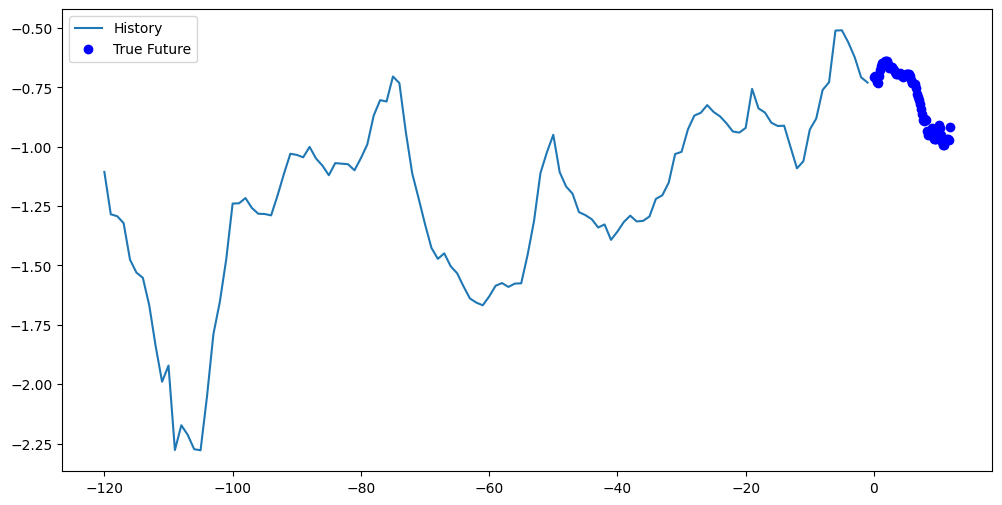

In [107]:
''' На этом и последующих аналогичных графиках история и будущие данные ежечасные. '''

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [108]:
''' Так как эта задача немного сложнее, чем предыдущая, то модель будет состоять из двух слоёв LSTM. 
    Наконец, поскольку выполняется 72 прогноза, выход слой насчитывает 72 нейрона. '''

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [109]:
''' Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки. '''

for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 0s 11ms/step
(256, 72)


In [110]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 25s 114ms/step - loss: 0.5142 - val_loss: 0.2869
Epoch 2/10
200/200 [==============================] - 21s 107ms/step - loss: 0.3443 - val_loss: 0.2813
Epoch 3/10
200/200 [==============================] - 21s 107ms/step - loss: 0.3430 - val_loss: 0.2621
Epoch 4/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2652 - val_loss: 0.2284
Epoch 5/10
200/200 [==============================] - 20s 101ms/step - loss: 0.2102 - val_loss: 0.2103
Epoch 6/10
200/200 [==============================] - 21s 106ms/step - loss: 0.2175 - val_loss: 0.2110
Epoch 7/10
200/200 [==============================] - 20s 102ms/step - loss: 0.2064 - val_loss: 0.2034
Epoch 8/10
200/200 [==============================] - 20s 102ms/step - loss: 0.2001 - val_loss: 0.2042
Epoch 9/10
200/200 [==============================] - 20s 102ms/step - loss: 0.2021 - val_loss: 0.1936
Epoch 10/10
200/200 [==============================] - 20s 102ms/step - l

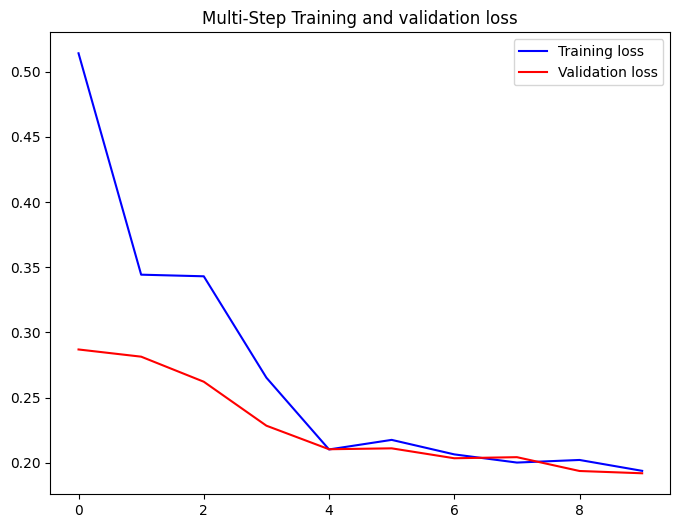

In [111]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [112]:
''' 
Выполнение интервального прогноза

Итак, давайте выясним, насколько успешно обученная ИНС справляется с прогнозами будущих значений температуры.
'''

' \nВыполнение интервального прогноза\n\nИтак, давайте выясним, насколько успешно обученная ИНС справляется с прогнозами будущих значений температуры.\n'

8/8 [==============================] - 0s 11ms/step


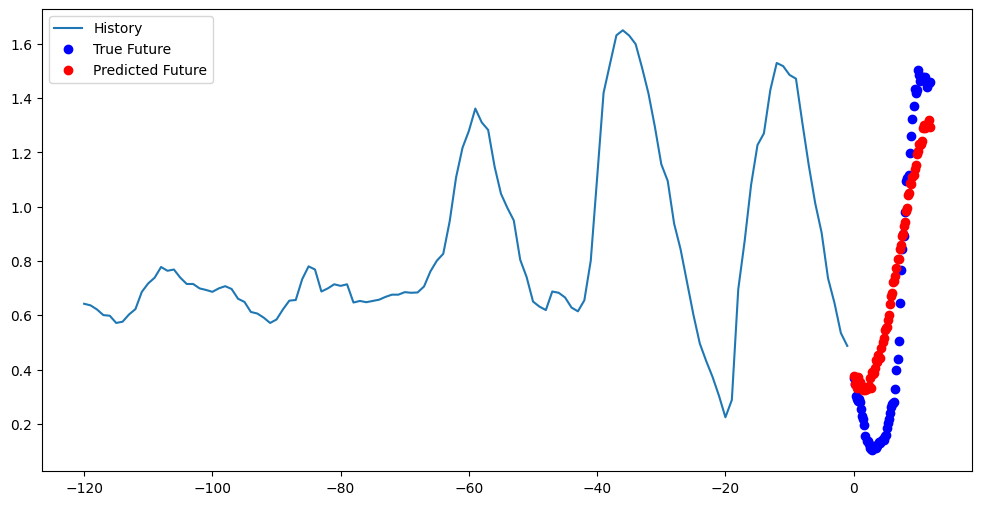

8/8 [==============================] - 0s 11ms/step


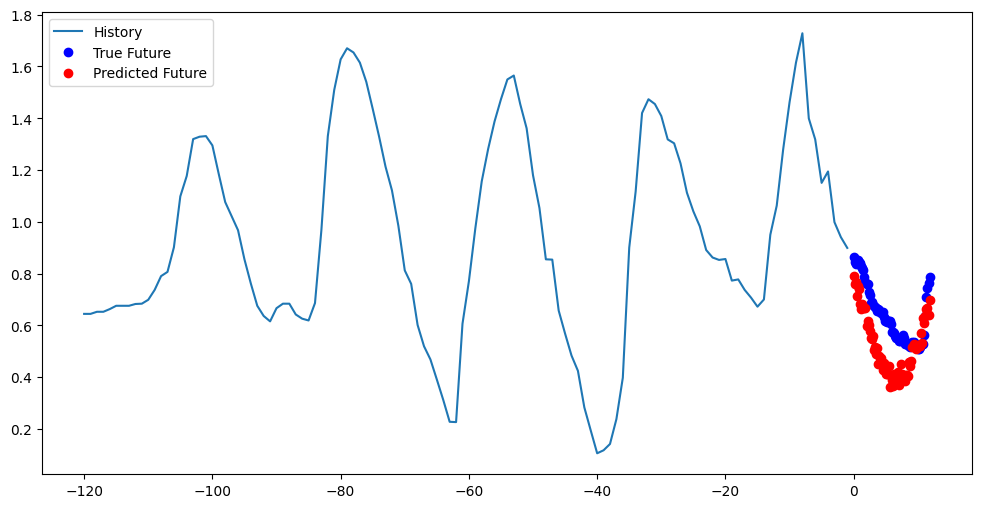

8/8 [==============================] - 0s 11ms/step


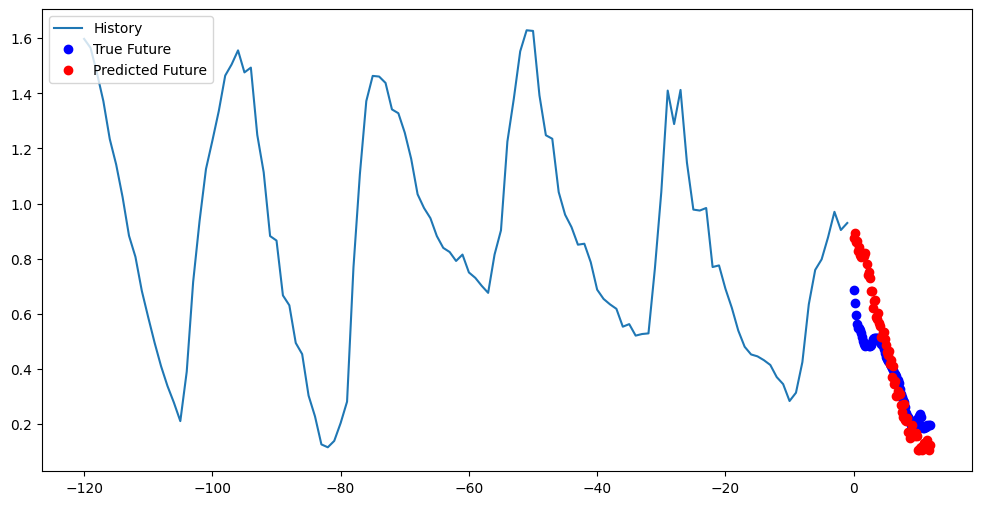

In [113]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])